## Resume Parser Benchmarking Notebook
This notebook benchmarks multiple free-tier LLMs to identify the best model for resume parsing, then uses that model to extract structured information from resumes.

### Environment setup and instructions: 
1. Create a virtual environment: virtualenv --python venv
2. Activate the virtual environment in windows: venv\Scripts\activate or source venv/bin/activate in macOS
3. Install required packages in requirements.txt file: pip install -r requirements.txt
4. Set personal API KEY: Create a .env file in the project root. Then add your Gemini API key: GEMINI_API_KEY='your_api_key'. 
5. Folder Structure: 
sample_resumes/ — contains resume files (PDF/DOCX) for testing
parsed_results/ — stores parsed outputs as timestamped JSON files
.env — holds your API key (excluded from GitHub via .gitignore)

6. Notebook workflow: this notebook is organized into 7 parts: 

(1) import packages 

(2) load API 

(3) Load data and data processing 

(4) Define prompt and call model  

(5)  Model prediction, selection and evaluation
   --Includes performance metrics and visualizations comparing models 

(6) Parse the results using the best performed model 
   --One resume example is used as an example ("resume1.pdf"). 
    The notebook will parse that file using the top-performing model and save the results.
    
(7) Save results as json file to the folder: parsed_results. 

## 1. Import packages

In [128]:
import fitz  # PyMuPDF
import docx
import os
import google.generativeai as genai
import json
import re
import json, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import google.generativeai as genai
from dotenv import load_dotenv
from typing import Dict
from datetime import datetime

## 2. Load API Key

Note: 

Save your API Key in a .env file: GEMINI_API_KEY='your_api_key'; 

Load it using python-dotenv. 

In [129]:
load_dotenv()
genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

## 3. Load data and data processing functions

In [130]:
# resume files folder path
resume_path = "sample_resumes/" 

# list all the resume examples' names
resume_files = [f for f in os.listdir(resume_path) if os.path.isfile(os.path.join(resume_path, f))]

In [131]:
# Manually labeled ground truth of resume examples in a separate json file for evaluation purpose
with open("ground_truth.json", "r") as f:
    ground_truth = json.load(f)

In [132]:
# read pdf format files
def read_pdf(file_path):
    doc = fitz.open(file_path)
    text = ""
    for page in doc:
        text += page.get_text()
    return text
# read word format files
def read_docx(file_path):
    doc = docx.Document(file_path)
    return "\n".join([para.text for para in doc.paragraphs])

In [133]:
# chunk the long text resume if length is over 10K with 500 overlap. 
def sliding_chunks(text, size=30000, overlap=500):
    return [text[i:i+size] for i in range(0, len(text), size - overlap)]

In [134]:
def normalize(value):
    # case insensitive handling: normalize all characters to lower case
    if isinstance(value, str):
        return value.lower().strip()
    elif isinstance(value, list):
        return [v.lower().strip() for v in value]
    else:
        return value

## 4. Define the Prompt and Call Gemini model

In [135]:
def extract_resume_info(text, model):
    # define prompt and use the model to extract name, email and skills in json format
    prompt = f"""
    Extract the name, email, and skills from the following resume text.
    Return only a valid JSON object with keys 'name', 'email', and 'skills' (as a list of strings).
    Do not include any explanation or extra text.

    Resume:
    {text}
    """
    start = time.time()
    response = model.generate_content(prompt)
    elapsed = time.time() - start

    # Parse the response safely
    try:
        json_match = re.search(r'\{.*\}', response.text, re.DOTALL)
        if json_match:
            result = json.loads(json_match.group())
        else:
            raise ValueError("No JSON found in response.")
    except Exception as e:
        print("Error parsing response:", e)
        result = {"name": None, "email": None, "skills": []}
    return result, elapsed

In [136]:
# Unified Parser to read text from PDF and word fromats
def parse_resume(file_name, model, file_path = "sample_resumes/"):
    ext = os.path.splitext(file_path + file_name)[-1].lower()
    if ext == ".pdf":
        text = read_pdf(file_path + file_name)
        if len(text) > 30000:
            text = sliding_chunks(text)
    elif ext == ".docx":
        text = read_docx(file_path + file_name)
        if len(text) > 30000:
            text = sliding_chunks(text)
    else:
        raise ValueError("Unsupported file format. Use PDF or DOCX.")
    return extract_resume_info(text, model)

## 5. Model prediction, selection and evaluation

Manually labeled the ground truth for each resume in ground_truth.json file. The prediction results using the model will be compared against the ground truth. 

Several models will be tested and compared, the most efficient and cost effective ones will be selected for in the production level. (Here is code to test a few free models)

#### 5.1 model list

In [137]:
# Test a list of gemini models
model_names = ["models/gemini-2.5-pro", 
               "models/gemini-1.5-flash-latest",
               "models/gemini-1.5-pro-latest",
               "models/gemini-1.5-pro",
               "models/gemini-1.5-flash-8b-latest",
               "models/gemini-2.5-flash",
               "models/gemini-2.0-flash"
               ]

#### 5.2 Evaluation function

In [138]:
def evaluate(parsed_results: Dict[str, dict], ground_truth: Dict[str, dict]):
    # Evaluate the parsed results(a dictionary with str as key and dict as value) by comapring with ground truth(same format as parsed results). 
    # Benchmarks: accuracy of name/email, precison/recall/F1 score for skills. 
    
    # A few variables to keep metrics
    total = len(parsed_results) # number of successfully parsed results
    name_matches = 0 # number of correctly parsed name results
    email_matches = 0 # number of correctly parsed email results
    precision_list = [] # skill precisions for all files
    recall_list = [] # skill recall for all files
    f1_list = [] # skill f1 for all files

    for file_name, predicted in parsed_results.items():
        actual = ground_truth.get(file_name, {})

        # Normalized results
        pred_name = normalize(predicted.get("name"))
        actual_name = normalize(actual.get("name"))
        pred_email = normalize(predicted.get("email"))
        actual_email = normalize(actual.get("email"))
        pred_skills = set(normalize(predicted.get("skills", [])))
        actual_skills = set(normalize(actual.get("skills", [])))

        #  Name & Email Accuracy
        if pred_name == actual_name:
            name_matches += 1
        else: 
            print(f"Name mismatch in {file_name}: predicted {pred_name} vs actual {actual_name}")
        if pred_email == actual_email:
            email_matches += 1
        else: 
            print(f"Email mismatch in {file_name}: predicted {pred_email} vs actual {actual_email}")

        # Skills Precision, Recall, F1 for each file
        if pred_skills:
            precision = len(actual_skills & pred_skills) / len(pred_skills)
        else:
            precision = 0

        if actual_skills:
            recall = len(actual_skills & pred_skills) / len(actual_skills)
        else:
            recall = 0

        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0

        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    # Aggregate Metrics
    name_accuracy = name_matches / total
    email_accuracy = email_matches / total
    avg_precision = sum(precision_list) / total
    avg_recall = sum(recall_list) / total
    avg_f1 = sum(f1_list) / total

    return name_accuracy, email_accuracy, avg_precision, avg_recall, avg_f1

#### 5.3 Run the models to make predictions and get metrics

In [139]:
all_model_parsed_results ={}
metrics_log = [] # metrics for model selectioin and evaluation
for model_name in model_names:
    print(f"\n Testing model: {model_name}")
    model = genai.GenerativeModel(model_name = model_name)
    
    success_count = 0
    failure_count = 0
    parsed_results = {}
    failed_files = []
    sum_elapsed = 0

    for file_name in resume_files:
        try: 
            parsed, elapsed = parse_resume(file_name, model, resume_path)
            parsed_results[file_name] = parsed
            success_count += 1
            sum_elapsed += elapsed
            print(f"✅ Parsed: {file_name}")

        except Exception as e:
            failure_count += 1
            failed_files.append(file_name)
            print(f"❌ Failed: {file_name} — {type(e).__name__}")
            # Optional: wait before next attempt to avoid rate limits
            #time.sleep(10)
            continue
    print(f"parsed results is {parsed_results}")

    if parsed_results: 
        all_model_parsed_results[model_name] = parsed_results
        total = len(resume_files)
        success_rate = success_count / total
        avg_latency = sum_elapsed /success_count
        
        name_matches, email_matches, precision, recall, f1 = evaluate(parsed_results, ground_truth)
    
        metrics_log.append({
                "model": model_name,
                "success rate": success_rate,
                "average_response_time": round(avg_latency, 2),
                "name_match": name_matches,
                "email_match": email_matches,
                "skills precision": round(precision, 3),
                "skills recall": round(recall, 3),
                "skills f1": round(f1, 3),
            })


 Testing model: models/gemini-2.5-pro
✅ Parsed: resume1.pdf
✅ Parsed: resume10.docx
✅ Parsed: resume11.docx
❌ Failed: resume12.docx — ResourceExhausted
✅ Parsed: resume13.docx
❌ Failed: resume14.docx — ResourceExhausted
❌ Failed: resume15.docx — ResourceExhausted
❌ Failed: resume2.pdf — ResourceExhausted
❌ Failed: resume3.pdf — ResourceExhausted
❌ Failed: resume4.pdf — ResourceExhausted
parsed results is {'resume1.pdf': {'name': 'John Huber', 'email': 'email@email.com', 'skills': ['HTML5', 'CSS', 'JavaScript', 'Adobe Suite', 'Sketch', 'InVision', 'Balsamiq', 'Time management', 'Self-motivated', 'Effective communicator', 'Team oriented', 'Adobe Photoshop', 'Illustrator']}, 'resume10.docx': {'name': 'Janna Gardner', 'email': 'janna@example.com', 'skills': ['Type 96 words per minute', 'Proficient with project management software', 'Team player', 'Excellent time management skills', 'Conflict management', 'Public speaking', 'Data analytics']}, 'resume11.docx': {'name': 'JACKY WILSON', 'ema

Some observations on this step: will visualize and compare metrics in the next following cells:

gemini-2.5-flash, gemini-2.0-flash successfully processed all resumes. 

name mismatch reported in resume15: predicted 'm. riley' vs actual 'may riley'.

In [140]:
metrics_log

[{'model': 'models/gemini-2.5-pro',
  'success rate': 0.4,
  'average_response_time': 12.91,
  'name_match': 1.0,
  'email_match': 1.0,
  'skills precision': 0.422,
  'skills recall': 0.583,
  'skills f1': 0.47},
 {'model': 'models/gemini-1.5-flash-latest',
  'success rate': 0.7,
  'average_response_time': 1.2,
  'name_match': 0.8571428571428571,
  'email_match': 1.0,
  'skills precision': 0.214,
  'skills recall': 0.333,
  'skills f1': 0.255},
 {'model': 'models/gemini-2.5-flash',
  'success rate': 1.0,
  'average_response_time': 7.01,
  'name_match': 0.9,
  'email_match': 1.0,
  'skills precision': 0.395,
  'skills recall': 0.567,
  'skills f1': 0.424},
 {'model': 'models/gemini-2.0-flash',
  'success rate': 1.0,
  'average_response_time': 1.06,
  'name_match': 0.9,
  'email_match': 1.0,
  'skills precision': 0.405,
  'skills recall': 0.533,
  'skills f1': 0.437}]

#### 5.4 Model comparison and visualization

In [141]:
# Compare models and get best one that serve your purpose with high success rate, name_match, precision, recall
df = pd.DataFrame(metrics_log)
df["model"] = df["model"].str.replace("models/", "")  # clean model names
# Select metrics to plot
metrics = ["success rate", "average_response_time", "name_match", "email_match",
           "skills precision", "skills recall", "skills f1"]

C:\Users\Jena\AppData\Local\Temp\ipykernel_1032\4009895493.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\Jena\Documents\professional\resumeParser\venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


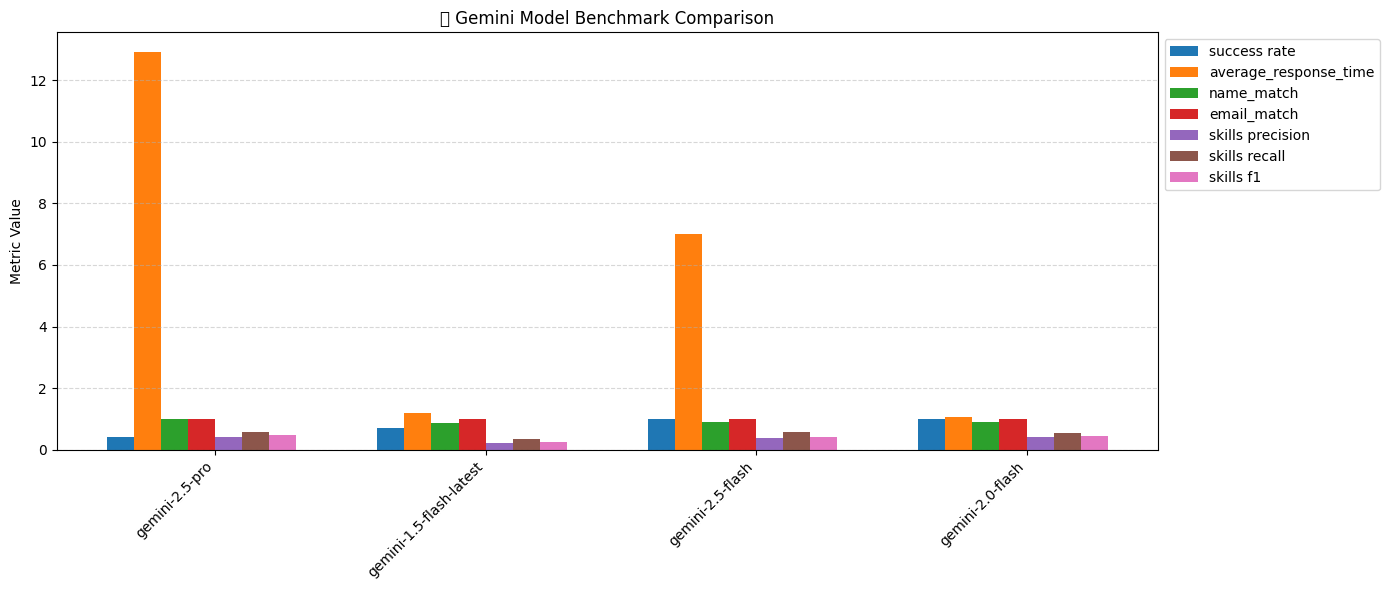

In [142]:
# Visulization
x = np.arange(len(df["model"]))  # Number of models
width = 0.1  # Width of each bar

# Plot
plt.figure(figsize=(14, 6))
for i, metric in enumerate(metrics):
    plt.bar(x + i * width, df[metric], width, label=metric)

# Labels and formatting
plt.xticks(x + width * (len(metrics) / 2), df["model"], rotation=45, ha="right")
plt.ylabel("Metric Value")
plt.title("📊 Gemini Model Benchmark Comparison")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

Summary: gemini-2.0-flash has the most balanced performace of success rate, skills precision, while the average response time is still short. So this model will be selected in the final pipeline. 

## 6. Parse the results using the best performed model

After the model selection, use the best performed model to parse resume one at each time

In [143]:
# resume file name: here we use resume1.pdf in the sample_resumes as an example
file_name = "resume1.pdf"

In [ ]:
# Use the picked model to parse the resume
model_name_picked = 'models/gemini-2.0-flash'
model_picked = genai.GenerativeModel(model_name = model_name_picked)
    

parsed_results = {}

try: 
    parsed, elapsed = parse_resume(file_name, model_picked, resume_path)
    parsed_results[file_name] = parsed
    success_count += 1
    sum_elapsed += elapsed
    print(f"✅ Parsed: {file_name}")

except Exception as e:
    failure_count += 1
    failed_files.append(file_name)
    print(f"❌ Failed: {file_name} — {type(e).__name__}")

print(f"parsed results is {parsed_results}")

if parsed_results:      
    name_accuracy, email_accuracy, precision, recall, f1 = evaluate(parsed_results, ground_truth)
    
    print(f"""model: {model_name_picked},
            success rate: {success_rate},
            response_time: {round(elapsed, 2)},
            name_match: {name_accuracy},
            email_match: {email_accuracy},
            skills precision: {round(precision, 3)},
            skills recall: {round(recall, 3)},
            skills f: {round(f1, 3)}"""
        )

✅ Parsed: resume1.pdf
parsed results is {'resume1.pdf': {'name': 'John Huber', 'email': 'email@email.com', 'skills': ['HTML5', 'CSS', 'JavaScript', 'Adobe Suite', 'Sketch', 'InVision', 'Balsamiq', 'Time management', 'Self-motivated', 'Effective communicator', 'Team oriented']}}
model: models/gemini-2.0-flash,
            success rate: 1.0,
            response_time: 1.05,
            name_match: 1.0,
            email_match: 1.0,
            skills precision: 0.727,
            skills recall: 1.0,
            skills f: 0.842


## 7. Save the results as json file

In [145]:
# Save the parsed results as a josn file: file name followed with the time stamp to avoid overwritten

# Create output folder
output_folder = "parsed_results"
os.makedirs(output_folder, exist_ok=True)

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = f"parsed_results_{timestamp}.json"
file_path = os.path.join(output_folder, filename)

with open(file_path, "w") as f:
    json.dump(parsed_results, f, indent=2)

print(f"✅ Saved parsed results to {file_path}")

✅ Saved parsed results to parsed_results\parsed_results_2025-09-22_15-10-45.json
